In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

tuberculosis_data = genfromtxt('tuberculosis.csv', delimiter=',') #in the form of [t, S,L,I,T]

torch.manual_seed(1234)

In [2]:
%%time

PATH = 'tuberculosis' 

class DINN(nn.Module):
    def __init__(self, t, S_data, L_data, I_data, T_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.L = torch.tensor(L_data)
        self.I = torch.tensor(I_data)
        self.T = torch.tensor(T_data)        
        self.N = torch.tensor(1001)

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learnable parameters
        self.delta_tilda  = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(500)
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(13)
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1)
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.143)
        self.k_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.5)
        self.r_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(2)
        self.r_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1)
        self.beta_prime_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(13)
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0)

        #matrices (x4 for S, L, I, T) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #values for norm
        self.S_max = max(self.S)
        self.S_min = min(self.S)
        self.L_max = max(self.L)
        self.L_min = min(self.L)
        self.I_max = max(self.I)
        self.I_min = min(self.I)
        self.T_max = max(self.T)
        self.T_min = min(self.T)

        #normalize 
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.L_hat = (self.L - self.L_min) / (self.L_max - self.L_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.T_hat = (self.T - self.T_min) / (self.T_max - self.T_min)

        #NN
        self.net_tuberculosis = self.Net_tuberculosis()
        self.params = list(self.net_tuberculosis.parameters())
        self.params.extend(list([self.delta_tilda  ,self.beta_tilda ,self.c_tilda ,self.mu_tilda ,self.k_tilda ,self.r_1_tilda ,self.r_2_tilda ,self.beta_prime_tilda ,self.d_tilda]))

        
    #force parameters to be in a range
    @property
    def delta(self):
        return torch.tanh(self.delta_tilda) * 20 + 500 #self.delta_tilda 
    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) * 3 + 12 #self.beta_tilda
    @property
    def c(self):
        return torch.tanh(self.c_tilda) * 2 + 1 #self.c_tilda
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) * 0.1 + 0.2 #self.mu_tilda
    @property
    def k(self):
        return torch.tanh(self.k_tilda) * 0.5 + 0.5 #self.k_tilda
    @property
    def r_1(self):
        return torch.tanh(self.r_1_tilda) + 2 #self.r_1_tilda
    @property
    def r_2(self):
        return torch.tanh(self.r_2_tilda) * 2 + 1 #self.r_2_tilda
    @property
    def beta_prime(self):
        return torch.tanh(self.beta_prime_tilda) * 3 + 12 #self.beta_prime_tilda
    @property
    def d(self):
        return torch.tanh(self.d_tilda) * 0.4 #self.d_tilda

    #nets
    class Net_tuberculosis(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_tuberculosis, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, L, I, T

        def forward(self, t):
            tuberculosis=F.relu(self.fc1(t))
            tuberculosis=F.relu(self.fc2(tuberculosis))
            tuberculosis=F.relu(self.fc3(tuberculosis))
            tuberculosis=F.relu(self.fc4(tuberculosis))
            tuberculosis=F.relu(self.fc5(tuberculosis))
            tuberculosis=F.relu(self.fc6(tuberculosis))
            tuberculosis=F.relu(self.fc7(tuberculosis))
            tuberculosis=F.relu(self.fc8(tuberculosis))
            tuberculosis=self.out(tuberculosis)
            return tuberculosis    

    def net_f(self, t_batch):       

        tuberculosis_hat = self.net_tuberculosis(t_batch)

        S_hat, L_hat, I_hat, T_hat = tuberculosis_hat[:,0], tuberculosis_hat[:,1], tuberculosis_hat[:,2], tuberculosis_hat[:,3]

        #S_hat
        tuberculosis_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #L_hat
        tuberculosis_hat.backward(self.m2, retain_graph=True)
        L_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_hat
        tuberculosis_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()
        
        #T_hat
        tuberculosis_hat.backward(self.m4, retain_graph=True)
        T_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        L = self.L_min + (self.L_max - self.L_min) * L_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        T = self.T_min + (self.T_max - self.T_min) * T_hat
     
        #equations
        f1_hat = S_hat_t - (self.delta - self.beta * self.c * S * I / self.N - self.mu * S) / (self.S_max - self.S_min) 
        f2_hat = L_hat_t - (self.beta * self.c * S * I / self.N - (self.mu + self.k + self.r_1) * L + self.beta_prime * self.c * T * 1/self.N) / (self.L_max - self.L_min) 
        f3_hat = I_hat_t - (self.k*L - (self.mu + self.d) * I - self.r_2 * I) / (self.I_max - self.I_min) 
        f4_hat = T_hat_t - (self.r_1 * L + self.r_2 * I - self.beta_prime * self.c * T * 1/self.N - self.mu*T) / (self.T_max - self.T_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, L_hat, I_hat, T_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        L_pred_list = []
        I_pred_list = []
        T_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, S_hat_pred, L_hat_pred, I_hat_pred, T_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_hat_pred)
        L_pred_list.append(self.L_min + (self.L_max - self.L_min) * L_hat_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_hat_pred)
        T_pred_list.append(self.T_min + (self.T_max - self.T_min) * T_hat_pred)

        loss = (
              torch.mean(torch.square(self.S_hat - S_hat_pred)) + torch.mean(torch.square(self.L_hat - L_hat_pred)) + 
              torch.mean(torch.square(self.I_hat - I_hat_pred)) + torch.mean(torch.square(self.T_hat - T_hat_pred))+
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat))
               )

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        # self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return S_pred_list, L_pred_list, I_pred_list, T_pred_list

CPU times: user 62 µs, sys: 4 µs, total: 66 µs
Wall time: 68.9 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0004, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0
CPU times: user 3.08 s, sys: 516 ms, total: 3.6 s
Wall time: 3.6 s


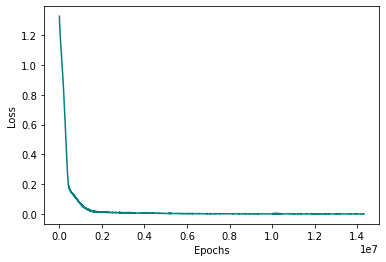

In [3]:
%%time

#this worked best
dinn = DINN(tuberculosis_data[0], tuberculosis_data[1], tuberculosis_data[2], tuberculosis_data[3], tuberculosis_data[4])

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, L_pred_list, I_pred_list, T_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, L_pred_list, I_pred_list, T_pred_list = dinn.train(1) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, L_pred_list, I_pred_list, T_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

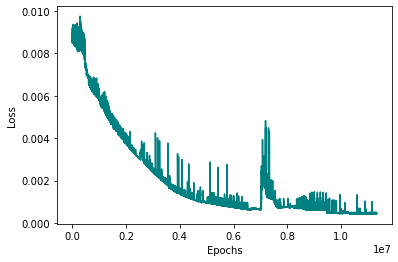

In [4]:
plt.plot(dinn.losses[3000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

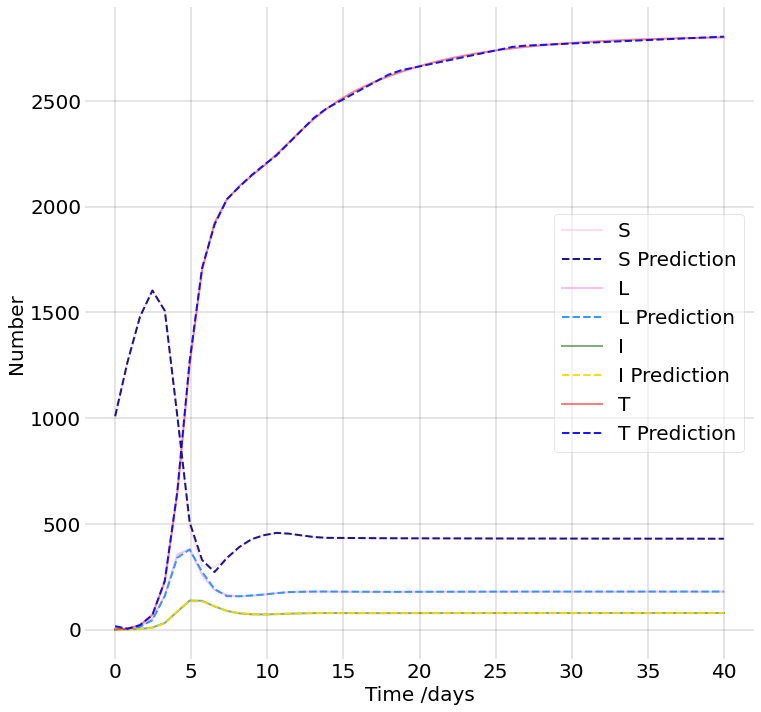

In [5]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(tuberculosis_data[0], tuberculosis_data[1], 'pink', alpha=0.5, lw=2, label='S')
ax.plot(tuberculosis_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

ax.plot(tuberculosis_data[0], tuberculosis_data[2], 'violet', alpha=0.5, lw=2, label='L')
ax.plot(tuberculosis_data[0], L_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='L Prediction', linestyle='dashed')

ax.plot(tuberculosis_data[0], tuberculosis_data[3], 'darkgreen', alpha=0.5, lw=2, label='I')
ax.plot(tuberculosis_data[0], I_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

ax.plot(tuberculosis_data[0], tuberculosis_data[4], 'red', alpha=0.5, lw=2, label='T')
ax.plot(tuberculosis_data[0], T_pred_list[0].detach().numpy(), 'blue', alpha=0.9, lw=2, label='T Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('tuberculosis.pdf')
plt.show()

tensor([509.4698], grad_fn=<AddBackward0>)
tensor([12.5441], grad_fn=<AddBackward0>)
tensor([1.0405], grad_fn=<AddBackward0>)
tensor([0.1474], grad_fn=<AddBackward0>)
tensor([0.5396], grad_fn=<AddBackward0>)
tensor([1.9892], grad_fn=<AddBackward0>)
tensor([1.1243], grad_fn=<AddBackward0>)
tensor([13.7384], grad_fn=<AddBackward0>)
tensor([-0.0421], grad_fn=<MulBackward0>)


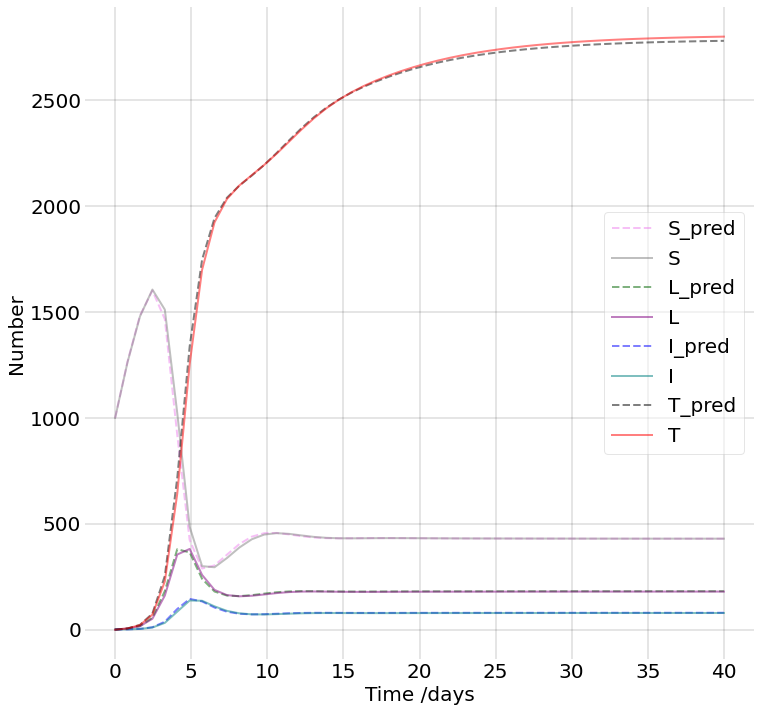

In [6]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
S0 = 1000
L0 = 0
I0 = 1
T0 = 0
N = 1001 #S0 + L0 + I0 + T0

# A grid of time points (in days)
t = np.linspace(0, 40, 50) 

#parameters
delta  = dinn.delta
print(delta)
beta = dinn.beta
print(beta)
c = dinn.c
print(c)
mu = dinn.mu
print(mu)
k = dinn.k
print(k)
r_1 = dinn.r_1
print(r_1)
r_2 = dinn.r_2
print(r_2)
beta_prime = dinn.beta_prime
print(beta_prime)
d = dinn.d
print(d)

# The SIR model differential equations.
def deriv(y, t, N, delta  ,beta ,c ,mu ,k ,r_1 ,r_2 ,beta_prime,d ):
    S, L, I, T= y

    dSdt = delta - beta * c * S * I / N - mu * S
    dLdt = beta * c * S * I / N - (mu + k + r_1) * L + beta_prime * c * T * 1/N
    dIdt = k*L - (mu + d) * I - r_2 * I
    dTdt = r_1 * L + r_2 * I - beta_prime * c * T * 1/N - mu*T

    return dSdt, dLdt, dIdt, dTdt


# Initial conditions vector
y0 = S0, L0, I0, T0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, delta  ,beta ,c ,mu ,k ,r_1 ,r_2 ,beta_prime,d ))
S, L, I, T = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='S_pred', linestyle='dashed')
ax.plot(tuberculosis_data[0], tuberculosis_data[1], 'grey', alpha=0.5, lw=2, label='S')

ax.plot(t, L, 'darkgreen', alpha=0.5, lw=2, label='L_pred', linestyle='dashed')
ax.plot(tuberculosis_data[0], tuberculosis_data[2], 'purple', alpha=0.5, lw=2, label='L')

ax.plot(t, I, 'blue', alpha=0.5, lw=2, label='I_pred', linestyle='dashed')
ax.plot(tuberculosis_data[0], tuberculosis_data[3], 'teal', alpha=0.5, lw=2, label='I')

ax.plot(t, T, 'black', alpha=0.5, lw=2, label='T_pred', linestyle='dashed')
ax.plot(tuberculosis_data[0], tuberculosis_data[4], 'red', alpha=0.5, lw=2, label='T')

ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [7]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
L_total_loss = 0
L_den = 0
I_total_loss = 0
I_den = 0
T_total_loss = 0
T_den = 0
for timestep in range(len(t)):
  S_value = tuberculosis_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (tuberculosis_data[1][timestep])**2

  L_value = tuberculosis_data[2][timestep] - L[timestep]
  L_total_loss += L_value**2
  L_den += (tuberculosis_data[2][timestep])**2

  I_value = tuberculosis_data[3][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (tuberculosis_data[3][timestep])**2
  T_value = tuberculosis_data[4][timestep] - T[timestep]
  T_total_loss += T_value**2
  T_den += (tuberculosis_data[4][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
L_total_loss = math.sqrt(L_total_loss/L_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
T_total_loss = math.sqrt(T_total_loss/T_den)

print('S_total_loss: ', S_total_loss)
print('I_total_loss: ', L_total_loss)
print('S_total_loss: ', I_total_loss)
print('I_total_loss: ', T_total_loss)

S_total_loss:  0.030650821025841598
I_total_loss:  0.03408923732149634
S_total_loss:  0.03394823623705112
I_total_loss:  0.008869211666442561
